In [1]:
# Importing relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
import os
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler
import warnings 
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

In [3]:
df = pd.read_csv("Data/Anomaly_data/244B_15dec2020_selectd.csv")
df.columns = ['DateTime','RS4B_ROAST.Campaign','RS4B_ROAST.Batch','RS4B_ROAST.Lot','244B_XV114.Out2','244B.CoffeeTargetTemperature',
              '244B_RTOComms.TE8R051','244B_SC220.OutputVoltage','244B_RTOComms.XV285','244B_FCV110.Output','244B_Sequences.Roasting',
              '244B_FCV110.Feedback','244B_VST220.AIn','244B_CO270.AIn','244B_TE118.AIn','244B_TE117.AIn','244B_TE116.AIn',
              '244B_SC220.SpdFB','244B_SC220.SpdSP','244B_SC150.SpdSP','244B_RTOComms.XV2853','244B_FCV127.Output','244B_FCV129.Feedback',
              '244B_RTOComms.XV2854','244B_FCV129.Output','244B_FCV545.Output','244B_SC220.SpdHz','244B_PDT100.AIn','244B_TE202.AIn',
              '244B_FQTI200.AIn','244B_TE200.AIn','244B_MachineModes.ModeMaster','244B_MachineModes.ModeDrum']
df.dropna(axis=0,inplace=True)
df["DateTime"]=pd.to_datetime(df.DateTime)
df.index = df.DateTime
df.drop(['DateTime'],axis=1,inplace = True)
print(df.shape)
df.head()

(2907222, 32)


,RS4B_ROAST.Campaign,RS4B_ROAST.Batch,RS4B_ROAST.Lot,244B_XV114.Out2,244B.CoffeeTargetTemperature,244B_RTOComms.TE8R051,244B_SC220.OutputVoltage,244B_RTOComms.XV285,244B_FCV110.Output,244B_Sequences.Roasting,...,244B_RTOComms.XV2854,244B_FCV129.Output,244B_FCV545.Output,244B_SC220.SpdHz,244B_PDT100.AIn,244B_TE202.AIn,244B_FQTI200.AIn,244B_TE200.AIn,244B_MachineModes.ModeMaster,244B_MachineModes.ModeDrum
DateTime,,,,,,,,,,,,,,,,,,,,,
2020-12-01 05:03:04.719,HOU 000119553,RS4B-RST000028,GRP113917,1.0,364.700012,324.299988,248.591751,99.786369,15.0,0.0,...,52.950912,30.0,100.0,32.150002,2.0,314.600006,-2.563555,260.200012,30.0,280.0
2020-12-01 05:03:04.782,HOU 000119553,RS4B-RST000028,GRP113917,1.0,363.900024,324.299988,248.591751,99.783318,15.0,0.0,...,55.794899,30.0,100.0,32.150002,2.0,314.600006,-2.441481,260.200012,30.0,280.0
2020-12-01 05:03:04.798,HOU 000119553,RS4B-RST000028,GRP113917,1.0,363.900024,324.299988,260.682373,99.783318,15.0,0.0,...,55.794899,30.0,100.0,33.712109,2.0,314.000000,-2.441481,259.899994,30.0,280.0
2020-12-01 05:03:05.226,HOU 000119553,RS4B-RST000028,GRP113917,1.0,363.700012,324.299988,260.682373,99.783318,15.0,0.0,...,55.794899,30.0,100.0,33.712109,2.0,314.000000,-2.441481,259.899994,30.0,280.0
2020-12-01 05:03:05.295,HOU 000119553,RS4B-RST000028,GRP113917,1.0,363.700012,323.700012,276.203430,99.786369,15.0,0.0,...,59.110016,30.0,100.0,35.703255,2.0,313.500000,-2.441481,259.399994,30.0,280.0


In [4]:
# Reading the Data
# df=pd.read_csv("Data/244B_Feb2022_selctd_tags.csv")
# df.columns=["DateTime", "244B_XV114.Out2", "244B_TE116.AIn", "244B_TE117.AIn", "244B_TE118.AIn", "244B_TE200.AIn" ,"244B_TE201.AIn" ,"244B_TE202.AIn", "244B_SC220.SpdFB", "244B_SC220.SpdSP", "244B_CO270.AIn", "244B_PDT100.AIn", "244B_MachineModes.ModeMaster", "244B_MachineModes.ModeDrum", "RS4B_ROAST.Batch" ,"RS4B_ROAST.Campaign", "RS4B_ROAST.Lot", "244B_CLoop.CurveRaw"]
# df.dropna(axis=0,inplace=True)
# df["DateTime"]=pd.to_datetime(df.DateTime)
# df.index = df.DateTime
# df.drop(['DateTime'],axis=1,inplace = True)
# print(df.shape)

In [5]:
df = df[(df['244B_MachineModes.ModeDrum'] >= 230) & (df['244B_MachineModes.ModeDrum'] <= 250) & (df['244B_MachineModes.ModeMaster'] == 30)] 
df.drop(['244B_MachineModes.ModeMaster','244B_MachineModes.ModeDrum','244B_XV114.Out2'],axis=1,inplace=True)
print(df.shape)
df.head()

(1927887, 29)


,RS4B_ROAST.Campaign,RS4B_ROAST.Batch,RS4B_ROAST.Lot,244B.CoffeeTargetTemperature,244B_RTOComms.TE8R051,244B_SC220.OutputVoltage,244B_RTOComms.XV285,244B_FCV110.Output,244B_Sequences.Roasting,244B_FCV110.Feedback,...,244B_FCV127.Output,244B_FCV129.Feedback,244B_RTOComms.XV2854,244B_FCV129.Output,244B_FCV545.Output,244B_SC220.SpdHz,244B_PDT100.AIn,244B_TE202.AIn,244B_FQTI200.AIn,244B_TE200.AIn
DateTime,,,,,,,,,,,,,,,,,,,,,
2020-12-01 05:03:09.683,HOU 000119553,RS4B-RST000028,GRP113917,0.0,323.0,285.078033,99.786369,100.0,0.0,29.840998,...,0.0,29.197058,62.583195,30.0,54.755676,37.407848,-2.051393,310.399994,-2.441481,258.700012
2020-12-01 05:03:09.691,HOU 000119553,RS4B-RST000028,GRP113917,0.0,323.0,285.078033,99.786369,100.0,0.0,29.840998,...,0.0,29.197058,59.777493,30.0,54.755676,37.407848,-2.051393,310.399994,-2.441481,258.700012
2020-12-01 05:03:09.693,HOU 000119553,RS4B-RST000028,GRP113917,0.0,323.0,271.029022,99.786369,100.0,0.0,29.840998,...,0.0,29.197058,59.777493,30.0,54.755676,35.632324,-2.051393,310.399994,-2.441481,258.700012
2020-12-01 05:03:09.695,HOU 000119553,RS4B-RST000028,GRP113917,0.0,323.0,271.029022,99.786369,100.0,0.0,29.840998,...,0.0,29.197058,59.777493,30.0,54.755676,35.632324,-2.051393,310.399994,-2.441481,258.700012
2020-12-01 05:03:09.696,HOU 000119553,RS4B-RST000028,GRP113917,0.0,323.0,271.029022,99.786369,100.0,0.0,29.840998,...,0.0,29.197058,59.777493,30.0,54.755676,35.632324,-2.051393,310.399994,-2.441481,258.700012


In [6]:
# iteration batch [0,24] ->then cycle [0,17]
# length = 1000 data points, RS4B_ROAST.Campaign

from sklearn.preprocessing import LabelEncoder
enc1 = LabelEncoder()
df['cycle'] = enc1.fit_transform(df['RS4B_ROAST.Batch'])
enc = LabelEncoder()
df['batch'] = enc.fit_transform(df['RS4B_ROAST.Lot'])
enc2 = LabelEncoder()
df['coffee_type'] = enc2.fit_transform(df['RS4B_ROAST.Campaign'])
df.head()

,RS4B_ROAST.Campaign,RS4B_ROAST.Batch,RS4B_ROAST.Lot,244B.CoffeeTargetTemperature,244B_RTOComms.TE8R051,244B_SC220.OutputVoltage,244B_RTOComms.XV285,244B_FCV110.Output,244B_Sequences.Roasting,244B_FCV110.Feedback,...,244B_FCV129.Output,244B_FCV545.Output,244B_SC220.SpdHz,244B_PDT100.AIn,244B_TE202.AIn,244B_FQTI200.AIn,244B_TE200.AIn,cycle,batch,coffee_type
DateTime,,,,,,,,,,,,,,,,,,,,,
2020-12-01 05:03:09.683,HOU 000119553,RS4B-RST000028,GRP113917,0.0,323.0,285.078033,99.786369,100.0,0.0,29.840998,...,30.0,54.755676,37.407848,-2.051393,310.399994,-2.441481,258.700012,27,0,8
2020-12-01 05:03:09.691,HOU 000119553,RS4B-RST000028,GRP113917,0.0,323.0,285.078033,99.786369,100.0,0.0,29.840998,...,30.0,54.755676,37.407848,-2.051393,310.399994,-2.441481,258.700012,27,0,8
2020-12-01 05:03:09.693,HOU 000119553,RS4B-RST000028,GRP113917,0.0,323.0,271.029022,99.786369,100.0,0.0,29.840998,...,30.0,54.755676,35.632324,-2.051393,310.399994,-2.441481,258.700012,27,0,8
2020-12-01 05:03:09.695,HOU 000119553,RS4B-RST000028,GRP113917,0.0,323.0,271.029022,99.786369,100.0,0.0,29.840998,...,30.0,54.755676,35.632324,-2.051393,310.399994,-2.441481,258.700012,27,0,8
2020-12-01 05:03:09.696,HOU 000119553,RS4B-RST000028,GRP113917,0.0,323.0,271.029022,99.786369,100.0,0.0,29.840998,...,30.0,54.755676,35.632324,-2.051393,310.399994,-2.441481,258.700012,27,0,8


In [7]:
df = df.resample("0.7S").median()
df.dropna(axis=0,inplace=True)
print(df.shape)
df.head()

(410434, 29)


,244B.CoffeeTargetTemperature,244B_RTOComms.TE8R051,244B_SC220.OutputVoltage,244B_RTOComms.XV285,244B_FCV110.Output,244B_Sequences.Roasting,244B_FCV110.Feedback,244B_VST220.AIn,244B_CO270.AIn,244B_TE118.AIn,...,244B_FCV129.Output,244B_FCV545.Output,244B_SC220.SpdHz,244B_PDT100.AIn,244B_TE202.AIn,244B_FQTI200.AIn,244B_TE200.AIn,cycle,batch,coffee_type
DateTime,,,,,,,,,,,,,,,,,,,,,
2020-12-01 05:03:09.500,0.0,323.000000,271.029022,99.786369,100.0,0.0,29.840998,0.070223,112.613297,783.449982,...,30.0,54.755676,35.632324,-2.051393,310.399994,-2.441481,258.700012,27.0,0.0,8.0
2020-12-01 05:03:10.200,0.0,322.449997,262.341843,99.786369,100.0,0.0,53.608814,0.068667,112.613297,782.549988,...,30.0,54.755676,34.386465,-2.051393,310.399994,-2.441481,259.150009,27.0,0.0,8.0
2020-12-01 05:03:10.900,0.0,321.899994,253.041153,70.625938,100.0,0.0,65.211952,0.067721,107.119965,781.400024,...,100.0,54.755676,33.028042,-2.051393,310.700012,-2.441481,259.899994,27.0,0.0,8.0
2020-12-01 05:03:11.600,0.0,321.899994,253.331543,54.817348,100.0,0.0,88.253426,0.066286,121.768852,780.799988,...,100.0,40.160736,33.000759,-2.051393,310.700012,-2.441481,260.500000,27.0,0.0,8.0
2020-12-01 05:03:12.300,0.0,321.899994,253.331543,51.857052,100.0,0.0,99.026459,0.064302,122.684410,779.599976,...,100.0,40.160736,33.000130,-1.849116,310.899994,-2.441481,261.600006,27.0,0.0,8.0


In [8]:
max(df.batch),max(df.cycle),max(df.coffee_type)

(28.0, 36.0, 15.0)

In [9]:
to_scale = []
for i in df.columns:
    if df[i].dtype != 'object' and max(df[i])-min(df[i])>100:
        to_scale.append(i)
print(to_scale)

['244B.CoffeeTargetTemperature', '244B_SC220.OutputVoltage', '244B_Sequences.Roasting', '244B_CO270.AIn', '244B_TE118.AIn', '244B_TE117.AIn', '244B_TE116.AIn', '244B_TE202.AIn', '244B_FQTI200.AIn', '244B_TE200.AIn']


In [10]:
scaler = MinMaxScaler(feature_range=(0, 100))
df[list(to_scale)] = scaler.fit_transform(df[list(to_scale)])
df.head()

,244B.CoffeeTargetTemperature,244B_RTOComms.TE8R051,244B_SC220.OutputVoltage,244B_RTOComms.XV285,244B_FCV110.Output,244B_Sequences.Roasting,244B_FCV110.Feedback,244B_VST220.AIn,244B_CO270.AIn,244B_TE118.AIn,...,244B_FCV129.Output,244B_FCV545.Output,244B_SC220.SpdHz,244B_PDT100.AIn,244B_TE202.AIn,244B_FQTI200.AIn,244B_TE200.AIn,cycle,batch,coffee_type
DateTime,,,,,,,,,,,,,,,,,,,,,
2020-12-01 05:03:09.500,0.0,323.000000,39.039566,99.786369,100.0,0.0,29.840998,0.070223,0.479117,45.355805,...,30.0,54.755676,35.632324,-2.051393,37.428892,0.051258,23.031655,27.0,0.0,8.0
2020-12-01 05:03:10.200,0.0,322.449997,35.173420,99.786369,100.0,0.0,53.608814,0.068667,0.479117,45.220974,...,30.0,54.755676,34.386465,-2.051393,37.428892,0.051258,23.362779,27.0,0.0,8.0
2020-12-01 05:03:10.900,0.0,321.899994,31.034236,70.625938,100.0,0.0,65.211952,0.067721,0.458286,45.048695,...,100.0,54.755676,33.028042,-2.051393,37.599551,0.051258,23.914644,27.0,0.0,8.0
2020-12-01 05:03:11.600,0.0,321.899994,31.163471,54.817348,100.0,0.0,88.253426,0.066286,0.513835,44.958802,...,100.0,40.160736,33.000759,-2.051393,37.599551,0.051258,24.356150,27.0,0.0,8.0
2020-12-01 05:03:12.300,0.0,321.899994,31.163471,51.857052,100.0,0.0,99.026459,0.064302,0.517307,44.779025,...,100.0,40.160736,33.000130,-1.849116,37.713306,0.051258,25.165573,27.0,0.0,8.0


In [11]:
'''
i = 0
c = df.iloc[i]['cycle']
b = df.iloc[i]['batch']
mini = 1500
count = 0
while i<len(df):
    if df.iloc[i]['batch']!=b:
        b = df.iloc[i]['batch']
        #print(c,':',count)
        mini = min(mini,count)
        count=0
        
    if df.iloc[i]['cycle']!=c:
        if count>0: 
            #print(c,':',count,end = '  ')
            mini = min(mini,count)
        c = df.iloc[i]['cycle']
        count=0
    count+=1
    i+=1
print('\n',mini)'''

"\ni = 0\nc = df.iloc[i]['cycle']\nb = df.iloc[i]['batch']\nmini = 1500\ncount = 0\nwhile i<len(df):\n    if df.iloc[i]['batch']!=b:\n        b = df.iloc[i]['batch']\n        #print(c,':',count)\n        mini = min(mini,count)\n        count=0\n        \n    if df.iloc[i]['cycle']!=c:\n        if count>0: \n            #print(c,':',count,end = '  ')\n            mini = min(mini,count)\n        c = df.iloc[i]['cycle']\n        count=0\n    count+=1\n    i+=1\nprint('\n',mini)"

# Auto-Encoder model

In [12]:
class Autoencoder(nn.Module):
    def __init__(self, output_len = 14,**kwargs):
        super().__init__()
        self.output_len = output_len
        self.batch,self.a,self.b = kwargs["input_shape"]
        self.layer_dim = 3
        self.hidden_dim = 16
        self.encoder = nn.LSTM(self.b, hidden_size = self.hidden_dim, num_layers=self.layer_dim, batch_first=True)
        self.hidden = nn.Linear(self.hidden_dim*self.a, 16*self.a)
        self.decoder = nn.Linear(16*self.a, self.output_len*self.a)

    def forward(self, x):
        batch = x.shape[0]
        x, (hn,cn) = self.encoder(x)
        x = x.reshape((batch,-1))
        #print(x.shape)
        x = self.hidden(x)
        x = self.decoder(x)
        out = x.view(batch,self.a,self.output_len)
        return out

In [13]:
model = Autoencoder(input_shape=(1,1000,27))
inp = torch.randn(1,1000,27)
out = model(inp)
print(out.shape)

torch.Size([1, 1000, 14])


In [14]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

480037232

# Training and validation

In [15]:
df.columns

Index(['244B.CoffeeTargetTemperature', '244B_RTOComms.TE8R051',
       '244B_SC220.OutputVoltage', '244B_RTOComms.XV285', '244B_FCV110.Output',
       '244B_Sequences.Roasting', '244B_FCV110.Feedback', '244B_VST220.AIn',
       '244B_CO270.AIn', '244B_TE118.AIn', '244B_TE117.AIn', '244B_TE116.AIn',
       '244B_SC220.SpdFB', '244B_SC220.SpdSP', '244B_SC150.SpdSP',
       '244B_RTOComms.XV2853', '244B_FCV127.Output', '244B_FCV129.Feedback',
       '244B_RTOComms.XV2854', '244B_FCV129.Output', '244B_FCV545.Output',
       '244B_SC220.SpdHz', '244B_PDT100.AIn', '244B_TE202.AIn',
       '244B_FQTI200.AIn', '244B_TE200.AIn', 'cycle', 'batch', 'coffee_type'],
      dtype='object')

In [16]:
input_column = ['244B.CoffeeTargetTemperature', '244B_RTOComms.TE8R051',
       '244B_SC220.OutputVoltage', '244B_RTOComms.XV285', '244B_FCV110.Output',
       '244B_Sequences.Roasting', '244B_FCV110.Feedback', '244B_VST220.AIn',
       '244B_CO270.AIn', '244B_TE118.AIn', '244B_TE117.AIn', '244B_TE116.AIn',
       '244B_SC220.SpdFB', '244B_SC220.SpdSP', '244B_SC150.SpdSP',
       '244B_RTOComms.XV2853', '244B_FCV127.Output', '244B_FCV129.Feedback',
       '244B_RTOComms.XV2854', '244B_FCV129.Output', '244B_FCV545.Output',
       '244B_SC220.SpdHz', '244B_PDT100.AIn', '244B_TE202.AIn',
       '244B_FQTI200.AIn', '244B_TE200.AIn', 'batch']

to_reconstruct = ['244B_TE116.AIn', '244B_TE117.AIn', '244B_TE118.AIn','244B_TE200.AIn', '244B_TE202.AIn',
                '244B_CO270.AIn', '244B_PDT100.AIn','244B_FCV127.Output','244B_FCV129.Output', '244B_FCV545.Output',
       '244B_SC220.SpdHz','244B_VST220.AIn', '244B_SC150.SpdSP','244B_FQTI200.AIn']

target_column = []

for i in df.columns:
    if i in to_reconstruct:
        target_column.append(i)
        
print(len(target_column),len(input_column))

14 27


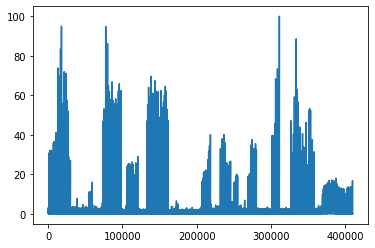

In [17]:
plt.plot(range(len(df)),df['244B_CO270.AIn'])

In [18]:
df = df.iloc[:10**5,:]
i=st=count = 0
c = df.iloc[i]['cycle']
b = df.iloc[i]['batch']
l = 950

x_data = []
y_data = []

while i<len(df):
    if df.iloc[i]['batch']!=b:
        b = df.iloc[i]['batch']
        x_data.append(np.array(df[input_column][i-l:i]))
        y_data.append(np.array(df[target_column][i-l:i]))
        st = i
        
    if df.iloc[i]['cycle']!=c:
        if i-st>=l: 
            x_data.append(np.array(df[input_column][i-l:i]))
            y_data.append(np.array(df[target_column][i-l:i]))
        c = df.iloc[i]['cycle']
        st = i
    i+=1
x_data = np.array(x_data)
y_data = np.array(y_data)
print(x_data.shape,y_data.shape)

(86, 950, 27) (86, 950, 14)


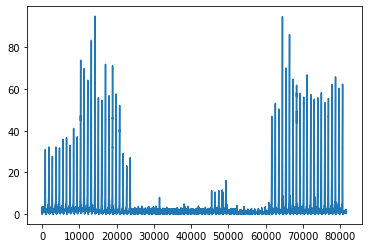

In [19]:
plt.plot(y_data[:,:,1].reshape(-1,1))

In [20]:
class Custom_data(Dataset):
    def __init__(self, x,y):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.y)

    def __getitem__(self, item):
        return self.x[item],self.y[item]
data = Custom_data(x_data,y_data)
#test_data = Custom_data(x_test,y_test)

In [32]:
train_loader = torch.utils.data.DataLoader(
    data, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)

# test_loader = torch.utils.data.DataLoader(
#     test_data, batch_size=32, shuffle=False, num_workers=4)

In [33]:
a = iter(train_loader)
b = next(a)
print(b[0].shape,b[1].shape)

torch.Size([1, 4800, 27]) torch.Size([1, 4800, 14])


In [21]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu

model = Autoencoder(output_len=14,input_shape = (1,950,27))

model = model.to(device)
model.load_state_dict(torch.load('saved_models/rca_tags_sampled.pt'))

<All keys matched successfully>

In [22]:
threshold = 80.6
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# mean-squared error loss
criterion = nn.MSELoss()

In [23]:
def predict(model, data, threshold):
    dl = torch.utils.data.DataLoader(data, batch_size=1, shuffle=False, num_workers=2)
    anomalous = []
    errors = []
    model.eval()
    with torch.no_grad():
        for idx,(x,y) in enumerate(dl):
            x = torch.from_numpy(x.numpy()).float().to(device)
            y = torch.from_numpy(y.numpy()).float().to(device)
            outputs = model(x)
            test_loss = criterion(outputs, y).item()
            errors.append(test_loss)
            if test_loss>threshold:
                anomalous.append(idx)
    #return anomalous,outputs.cpu().numpy(), batch_features.cpu().numpy()
    return anomalous,errors

In [24]:
anomaly, errors = predict(model, data, threshold=125)

50


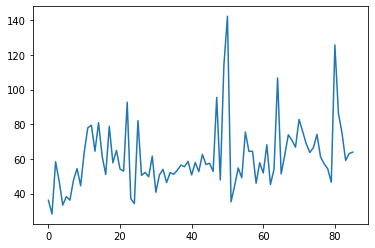

In [25]:
print(errors.index(max(errors)))
plt.plot(errors)

In [26]:
print(anomaly)

[50, 80]


In [27]:
for i in anomaly:
    print('index:',i,errors[i],'time:',df.index[i*l],'to',df.index[(i+1)*l])

index: 50 142.2526397705078 time: 2020-12-02 07:05:46.800000 to 2020-12-02 07:17:52
index: 80 125.68675231933594 time: 2020-12-03 14:39:11.900000 to 2020-12-03 14:50:50.500000


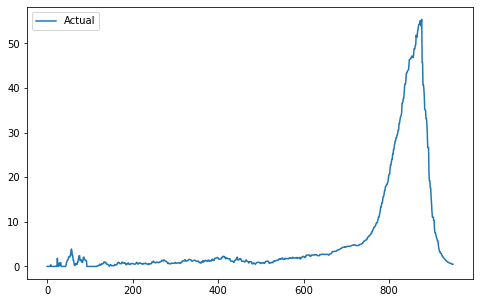

In [28]:
plt.figure(figsize = (8,5))
ind = target_column.index('244B_CO270.AIn')
plt.plot(y_data[80,:,ind].reshape(-1,1), label = 'Actual')
plt.legend()
plt.show()

In [29]:
print(max(y_data[:,:,ind].reshape((-1,1))))
list(y_data[:,:,ind].reshape((-1,1))).index(max(y_data[:,:,ind].reshape((-1,1))))/l

[94.98663086]


14.998947368421053

In [30]:
def reconstruct(model, data):
    dl = torch.utils.data.DataLoader(data, batch_size=10, shuffle=False, num_workers=2)
    
    errors = []
    model.eval()
    with torch.no_grad():
        for idx,(x,y) in enumerate(dl):
            x = torch.from_numpy(x.numpy()).float().to(device)
            y = torch.from_numpy(y.numpy()).float().to(device)
            outputs = model(x)
            test_loss = criterion(outputs, y).item()
            errors.append(test_loss)
    return errors,outputs.cpu().numpy(), y.cpu().numpy()
data2 = Custom_data(x_data[80:81],y_data[80:81])
error,reconstructions,data1 = reconstruct(model, data2)
print(error)

[125.68675231933594]


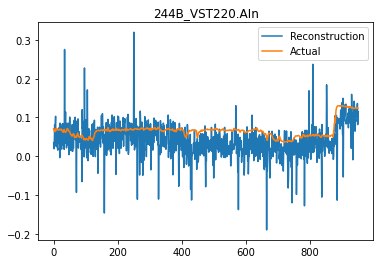

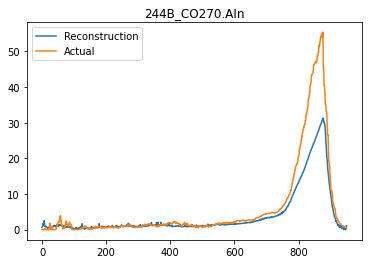

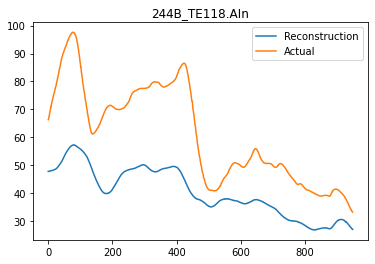

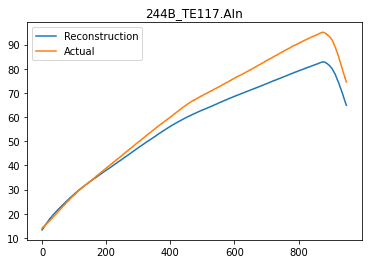

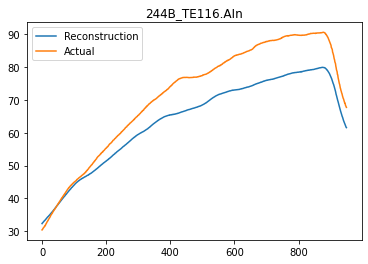

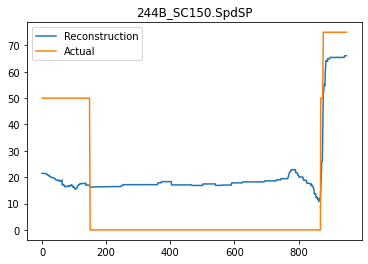

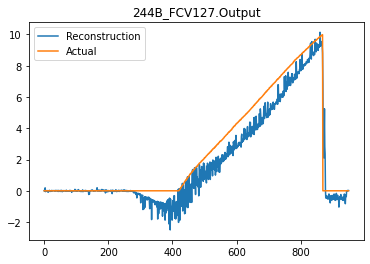

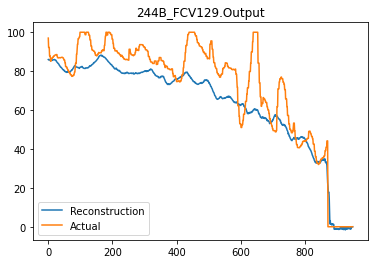

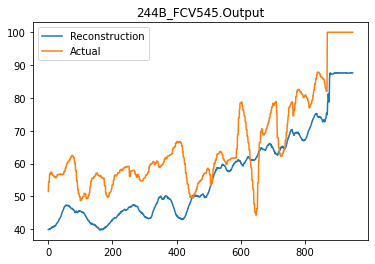

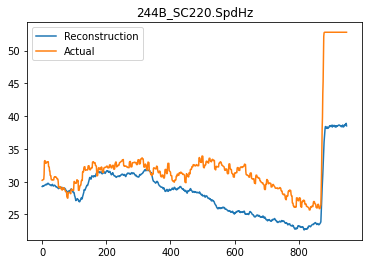

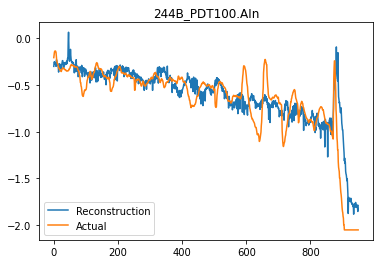

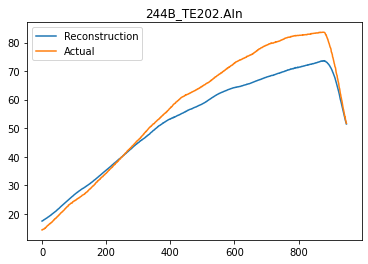

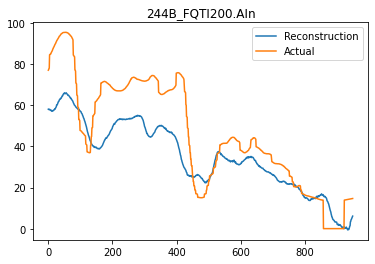

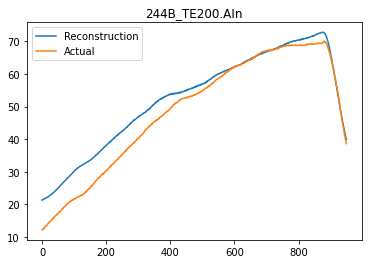

In [31]:
#plt.figure(figsize = (8,5))
#ind = target_column.index('244B_CO270.AIn')
for ind in range(14):
    plt.plot(reconstructions[:,:,ind].reshape(-1,1),label = 'Reconstruction')
    plt.plot(data1[:,:,ind].reshape(-1,1), label = 'Actual')
    plt.legend()
    plt.title(target_column[ind])
    plt.show()

In [69]:
print(target_column)

['244B_VST220.AIn', '244B_CO270.AIn', '244B_TE118.AIn', '244B_TE117.AIn', '244B_TE116.AIn', '244B_SC150.SpdSP', '244B_FCV127.Output', '244B_FCV129.Output', '244B_FCV545.Output', '244B_SC220.SpdHz', '244B_PDT100.AIn', '244B_TE202.AIn', '244B_FQTI200.AIn', '244B_TE200.AIn']


# Use Me

In [45]:
def get_threshold(model, criterion,train_loader):
    model.eval()
    with torch.no_grad():
        train_loss = []
        for idx,batch_features in enumerate(train_loader):
            batch_features = torch.from_numpy(batch_features.numpy()).float().to(device)
            outputs = model(batch_features)
            loss = criterion(outputs, batch_features).item()
            train_loss.append(loss)
        train_loss = np.array(train_loss)
    threshold = np.mean(train_loss) + np.std(train_loss)
    print('Threshold:', threshold)
    return threshold

In [46]:
threshold = get_threshold(model, criterion,train_loader)

Threshold: 4.060076478412851


In [39]:
def predict(model, data, threshold):
    dl = torch.utils.data.DataLoader(data, batch_size=32, shuffle=False, num_workers=2)
    anomalous = []
    model.eval()
    with torch.no_grad():
        for idx,batch_features in enumerate(dl):
            batch_features = torch.from_numpy(batch_features.numpy()).float().to(device)
            outputs = model(batch_features)
            test_loss = criterion(outputs, batch_features).item()
            if test_loss>threshold:
                anomalous.append(idx*32)
    return anomalous

In [49]:
# if list is empty, there is no anomaly
# number i in anomaly list indicates that data[i:i+32*200] contain anomalous data

anomaly = predict(model, test_data, threshold*1.2)
anomaly

[]

In [45]:
data1 = np.array(df[target_column][94600:94800])
data1 = data1.reshape((1,200,12))
anomaly = predict(model, data1, threshold*1.3)
anomaly

[0]

In [48]:
anomaly = predict(model, train_data, threshold*1.2)
anomaly

[]

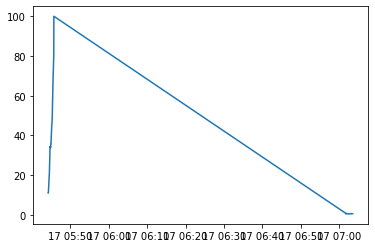

In [54]:
plt.plot(df['244B_CO270.AIn'][94600:94800])

In [53]:
for i in range(900,999):
    data1 = np.array(df[target_column][i*100:i*100+200])
    data1 = data1.reshape((1,200,12))
    anomaly = predict(model, data1, threshold*1.3)
    if len(anomaly)>0:
        print(i,end = ' ')

930 938 939 946 947 954 955 956 963 964 971 972 979 980 994 995 

In [ ]:
def train_model(model,criterion,optimizer,epochs=5):
    hist = {'loss':[], 'val_loss': []}
    for epoch in range(epochs):
        loss = 0
        print(f'Epoch: {epoch+1}/{epochs}')
        print('-'*25)
        model.train()
        for x,y in train_loader:
            x = torch.from_numpy(x.numpy()).float().to(device)
            y = torch.from_numpy(y.numpy()).float().to(device)
            optimizer.zero_grad()

            outputs = model(x)

            train_loss = criterion(outputs, y)
            train_loss.backward()
            optimizer.step()
            loss += train_loss.item()

        loss = loss / len(train_loader)
        hist['loss'].append(loss)
        
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for x,y in test_loader:
                x = torch.from_numpy(x.numpy()).float().to(device)
                y = torch.from_numpy(y.numpy()).float().to(device)
                outputs = model(x)
                val_loss += criterion(outputs, y).item()
        val_loss/=len(test_loader)
        hist['val_loss'].append(val_loss)
        # display the epoch training loss
        print(f"loss = {loss}, val_loss = {val_loss}")
    return hist

In [ ]:
hist = train_model(model,criterion,optimizer,epochs=5)

In [ ]:
plt.plot(range(len(hist['loss'])), hist['loss'], label = 'Train_loss')
plt.plot(range(len(hist['loss'])), hist['val_loss'], label = 'Validation_loss')
plt.legend()
plt.show()